In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths
from syspy.skims import skims
from quetzal.io import excel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [ ]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [5]:
sm.links.shape

(351366, 8)

### Prepare links for pathfinder

In [8]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

array([<AxesSubplot:title={'center':'a'}, xlabel='route_type'>],
      dtype=object)

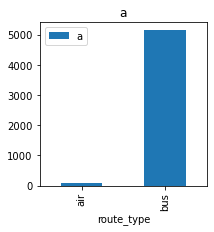

In [11]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg(
    {'a': 'count'}).plot.bar(subplots=True, figsize=(3,3))

In [12]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [ ]:
# Set a maximum headway
for mode in sm.pt_route_types:
    mask = sm.links['route_type']==mode
    sm.links.loc[mask, 'headway'] = np.minimum(
        sm.links.loc[mask, 'headway'], params['max_headway'][mode])

In [16]:
sm.links['headway'] = sm.links['headway'].astype(int)

<AxesSubplot:>

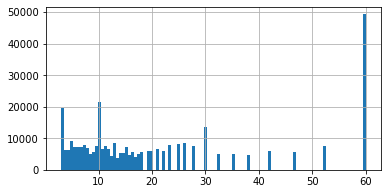

In [17]:
# Waiting time distribution in minutes
if manual: (sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [18]:
sm.links['headway'].mean()/60/2

22.832833213799855

In [19]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = params['transfer_penalty']
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict) # in s

In [20]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [21]:
sm.links.sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,route_type_disagg,headway,boarding_time,length
index,,,,,,,,,,,,
r_l_8703,rail_long,"LINESTRING (9.92607 51.53682, 9.74102 52.37676)",r_l_n_392,r_l_n_1161,7,rail_long_3,2220,rail_long_1650,rail_long,1200,1800,94254.0


In [22]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [23]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [24]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long' in x or
                          'rail_short' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [25]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [26]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|█████████████████████████████████████████████████████████| 18/18 [40:04<00:00, 133.61s/it]


In [27]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
5583,DE121,DEF08,40912.94245,"[DE121, coach_n_FLIXBUS:12288, coach_19212, co...",False,mode_breaker,"{bus, rail_long, rail_short}"


In [28]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|██████████████████████████████████████████████████████| 2496484/2496484 [03:19<00:00, 12495.33it/s]


In [29]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

2496484


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
130642,DEB3G,DEB38,18044.253604,"[DEB3G, bus_n_397060, bus_1003146, bus_1003152...",False,mode_breaker,"{air, rail_long, rail_short}","[bus_n_397060, coach_n_FLIXBUS:341, bus_n_2635...","[bus_n_194568, coach_n_FLIXBUS:371, bus_n_1753...","[bus_n_397060, bus_n_194568, r_l_n_620, coach_...","[bus_1003146, bus_1003152, bus_1003153, coach_...","[(bus_n_194568, r_l_n_620), (r_l_n_620, coach_...","[(DEB3G, bus_n_397060), (bus_n_69222, DEB38)]","[bus_n_76410, bus_n_296860]","[bus_1003146, coach_4187, bus_2467995, bus_192...","[bus_1003153, coach_4189, bus_2468013, bus_192...",False,5,9877,126956.376
17207,DE148,DEF03,59565.427821,"[DE148, coach_n_FLIXBUS:1694, coach_6380, coac...",False,mode_breaker,"{rail_long, air, bus, rail_short}","[coach_n_FLIXBUS:1694, coach_n_FLIXBUS:10]","[coach_n_FLIXBUS:10, coach_n_FLIXBUS:814]","[coach_n_FLIXBUS:1694, coach_n_FLIXBUS:10, coa...","[coach_6380, coach_6381, coach_6382, coach_186...",[],"[(DE148, coach_n_FLIXBUS:1694), (coach_n_FLIXB...",[coach_n_FLIXBUS:10],"[coach_6380, coach_18605]","[coach_6382, coach_18606]",False,1,48300,898688.464
98307,DEA15,DE21J,35628.416833,"[DEA15, r_l_n_808, bus_n_304031, r_s_n_76, r_s...",False,mode_breaker,"{rail_long, air, bus}","[r_s_n_76, coach_n_FLIXBUS:11548, r_s_n_14332,...","[r_s_n_2720, coach_n_FLIXBUS:28, r_s_n_6135, r...","[r_l_n_808, bus_n_304031, r_s_n_76, r_s_n_2720...","[r_s_104041, r_s_104042, r_s_104043, r_s_10404...","[(r_l_n_808, bus_n_304031), (bus_n_304031, r_s...","[(DEA15, r_l_n_808), (r_s_n_13853, DE21J)]",[],"[r_s_104041, coach_19429, r_s_126412, r_s_99444]","[r_s_104052, coach_19432, r_s_126425, r_s_99455]",False,3,25740,513573.856


### Add attributes to LoS table

In [30]:
# Add distances (Only path, not access/egress)
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [31]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
#    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
sm.pt_los.columns

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'length', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'boarding_time',
       'time'],
      dtype='object')


In [32]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
16094,2,139276.000,12274.395639,2215.528985,714.866654,6300,1244.0,1800,10474.395639
158422,3,531572.704,33793.863714,1900.068503,435.795211,18750,7308.0,5400,28393.863714


In [33]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [34]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [35]:
# Add price, parametrisation comes later because
# our GTFS feeds come without fares
sm.pt_los['price'] = 0

In [36]:
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type,price
95813,DE94F,DEF0D,14117.33053,"[DE94F, bus_n_399010, r_s_n_14951, r_s_133697,...",False,mode_breaker,{air},"[r_s_n_14951, r_s_n_7608, bus_n_285219, bus_n_...","[r_s_n_3733, r_s_n_11117, bus_n_55423, bus_n_3...","[bus_n_399010, r_s_n_14951, r_s_n_3733, bus_n_...",...,190200.0,2243.979514,278.851016,8640,1754.5,1200,12917.330529,"{rail_short, bus}",rail_short,0


In [37]:
# Make a safety copy before restricting results
#los = sm.pt_los.copy()

In [38]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [39]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

(1823273, 30)

In [40]:
# Berlin - Hamburg
if manual: all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.72it/s]


In [41]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
15831,0,276204.768,{coach},[coach_14310],16503.611983,1203.611983,0.000000,11100,600.0,3600,12903.611983
106405,0,257606.000,{rail_short},"[r_s_64757, r_s_64758, r_s_64759, r_s_64760, r...",13762.540190,1208.537477,314.002713,8040,3600.0,600,13162.540190
234386,0,241407.000,{rail_long},[r_l_4271],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001
332564,0,241407.000,{rail_long},[r_l_7955],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001
481548,0,276204.768,{coach},[coach_14353],16503.611983,1203.611983,0.000000,11100,600.0,3600,12903.611983
774680,0,241407.000,{rail_long},[r_l_10],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001
909478,0,241407.000,{rail_long},[r_l_3348],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001
1027375,0,241407.000,{rail_long},[r_l_6427],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001
1107683,0,276204.768,{coach},[coach_14401],16503.611983,1203.611983,0.000000,11100,600.0,3600,12903.611983
1290700,0,241407.000,{rail_long},[r_l_7253],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001


In [42]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x or 'air' in x))]
sm.pt_los.shape

(1577764, 30)

In [43]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

(1577764, 30)

In [44]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<params['restrict_los']['max_duration']]
sm.pt_los.shape

(1555605, 30)

array([<AxesSubplot:title={'center':'time'}>], dtype=object)

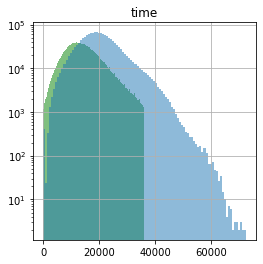

In [45]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

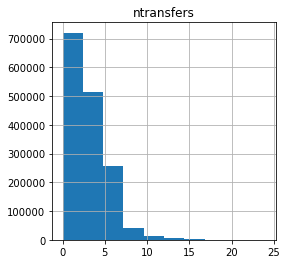

In [46]:
if manual: sm.pt_los.hist(column='ntransfers', figsize=(4,4))

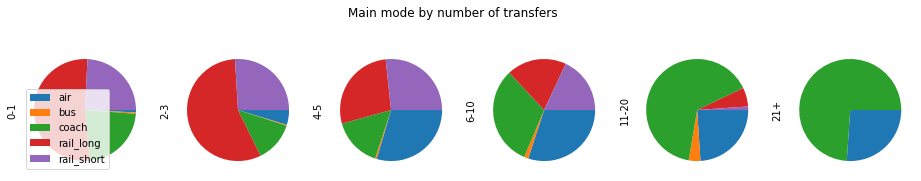

In [47]:
# Main mode distribution by transfers
if manual:
    t = sm.pt_los.copy()
    t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                       labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by number of transfers',
        legend=False, labeldistance=None)
    axs[0].legend(loc='lower left')

<AxesSubplot:xlabel='route_types'>

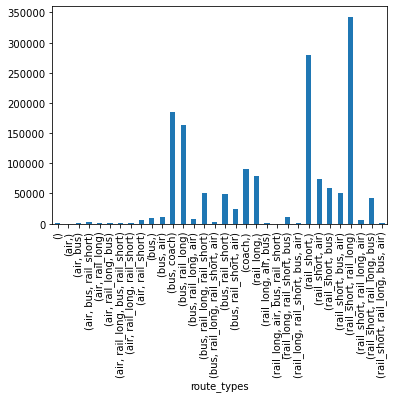

In [48]:
# Distribution of mode combinations
if manual:
    t['route_types'] = t['route_types'].apply(tuple)
    t.groupby('route_types').count()['route_type'].plot(kind='bar')

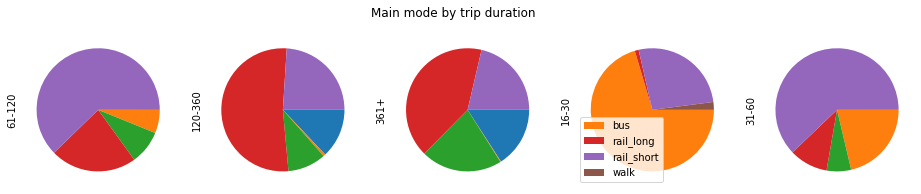

In [49]:
if manual:
    t['time'] = t['time'] / 60
    t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                       labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by trip duration',
        legend=False, labeldistance=None)
    axs[3].legend()

In [50]:
if manual: t = None

In [51]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=
                              params['restrict_los']['max_transfers']]
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('coach')])>2)
                                ))]
    sm.pt_los.shape

(1491509, 30)
(1439519, 30)


In [52]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(
        params['restrict_los']['n_fastest_trips']).reset_index()
sm.pt_los.shape

(719558, 30)

In [53]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') &
                            (sm.pt_los['length']>params['restrict_los']['max_dist_bus']))]
sm.pt_los.shape

(718690, 30)

In [53]:
# Also drop coach trips for local transport
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                            (sm.pt_los['length']<params['restrict_los']['min_dist_coach']))]
sm.pt_los.shape

(718690, 30)

<AxesSubplot:xlabel='route_types'>

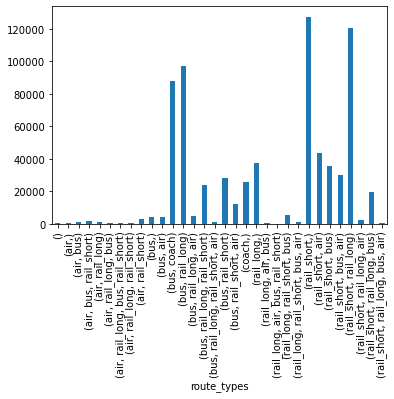

In [54]:
if manual: sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

array([<AxesSubplot:title={'center':'time'}>], dtype=object)

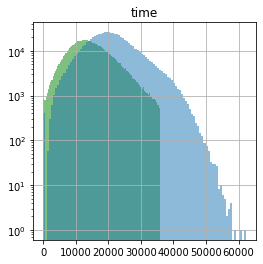

In [55]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

In [56]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
246229,0,276204.768,"(coach,)",[coach_14353],16503.611983,1203.611983,0.000000,11100,600.0,3600,12903.611983
246230,0,241407.000,"(rail_long,)",[r_l_4710],9336.373001,1236.373001,0.000000,5580,720.0,1800,7536.373001
246231,0,257606.000,"(rail_short,)","[r_s_64757, r_s_64758, r_s_64759, r_s_64760, r...",13762.540190,1208.537477,314.002713,8040,3600.0,600,13162.540190


In [57]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112')&(sm.pt_los['destination']=='DE111')]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price
1931,DE112,DE111,"(bus,)",3697.402655,"(DE112, coach_n_FLIXBUS:4278, r_s_n_7349, bus_...",False,mode_breaker,"{air, rail_short}","[bus_n_222552, bus_n_301561, bus_n_310057]","[bus_n_4318, bus_n_310057, bus_n_145916]",...,11131.000,11131.000,1303.832588,474.570067,780,1139.0,0,3697.402655,bus,0
1932,DE112,DE111,"(coach,)",15313.832588,"(DE112, coach_n_FLIXBUS:4278, coach_1875, coac...",False,mode_breaker,"{rail_long, air, bus, rail_short}","[coach_n_FLIXBUS:4278, coach_n_FLIXBUS:8058]","[coach_n_FLIXBUS:8058, coach_n_FLIXBUS:17]",...,44668.656,44668.656,1303.832588,0.000000,4500,2310.0,7200,8113.832588,coach,0
1933,DE112,DE111,"(rail_long,)",6114.595849,"(DE112, coach_n_FLIXBUS:4278, r_l_n_601, r_l_6...",False,mode_breaker,"{air, bus, rail_short}",[r_l_n_601],[r_l_n_742],...,16857.000,16857.000,1202.389299,112.206550,1200,1800.0,1800,4314.595849,rail_long,0
1934,DE112,DE111,"(rail_short,)",3307.473859,"(DE112, coach_n_FLIXBUS:4278, r_l_n_1033, bus_...",False,mode_breaker,"{air, bus}",[r_s_n_2800],[r_s_n_13489],...,9427.000,9427.000,1303.832588,388.641271,540,475.0,600,2707.473859,rail_short,0


In [58]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

711922

In [59]:
assert len(sm.pt_los.loc[sm.pt_los.isna().any(axis=1)])==0

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price


## Save model

In [60]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [61]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [62]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [63]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type,price
563595,DEB35,DE21A,"(rail_short, air)","[r_s_166580, r_s_166581, r_s_166582, r_s_16658...",1,325260,1440,763,4680,3236,10120,air,0


In [64]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:30<00:00,  1.17it/s]
